In [ ]:
import os
os.chdir('C:/AI Resume Matcher')
import pandas as pd
import numpy as np
import logging
import sys
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc,classification_report
# Add project root to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from src.preprocessing import preprocess_text
from src.feature_engineering import combine_features
from src.models import train_traditional_models, train_bert, EnsembleModel, MatchDataset
from src.evaluate import evaluate_model
from src.utils import save_model
from sentence_transformers import util
from transformers import RobertaTokenizer
import joblib
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

c:\AI Resume Matcher\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load data
train_df = pd.read_csv('data/processed/train_clean.csv')
val_df = pd.read_csv('data/processed/val_clean.csv')
# Verify required columns
required_columns = ['cv_final', 'jd_final', 'ai_prediction']
for df, name in [(train_df, 'Training'), (val_df, 'Validation')]:
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        logger.warning(f"{name} data missing columns: {missing_cols}")

# Create combined text
def create_combined_text(df, cv_col='cv_final', jd_col='jd_final'):
    cv_text = df[cv_col].fillna('')
    jd_text = df[jd_col].fillna('')
    return cv_text + ' [SEP] ' + jd_text

train_texts = create_combined_text(train_df)
val_texts = create_combined_text(val_df)

# Get labels
train_labels = train_df['ai_prediction'].values
val_labels = val_df['ai_prediction'].values

logger.info(f"Training data shape: {train_df.shape}")
logger.info(f"Validation data shape: {val_df.shape}")
logger.info(f"Label distribution in training: {np.bincount(train_labels)}")
logger.info(f"Label distribution in validation: {np.bincount(val_labels)}")


INFO:__main__:Training data shape: (5224, 10)
INFO:__main__:Validation data shape: (653, 10)
INFO:__main__:Label distribution in training: [2701 2523]
INFO:__main__:Label distribution in validation: [338 315]


In [3]:
# Train Traditional NLP Models
logger.info("\n" + "="*50)
logger.info("TRAINING TRADITIONAL NLP MODELS")
logger.info("="*50)

# Compute features outside if/else to ensure X_val is always defined
X_train, X_val, feats = combine_features(train_df, val_df)

traditional_model_path = 'models/best_traditional.pkl'
if os.path.exists(traditional_model_path):
    logger.info("Loading saved traditional models...")
    best_traditional_model = joblib.load(traditional_model_path)
    # Assume feats and X_val are compatible with the saved model
else:
    traditional_results = train_traditional_models(X_train, train_labels, X_val, val_labels)
    best_model_name = traditional_results['best_model']
    best_traditional_model = traditional_results[best_model_name]['model']
    os.makedirs('models', exist_ok=True)  # Ensure models directory exists
    save_model(best_traditional_model, traditional_model_path)
    save_model(feats['tfidf'], 'models/tfidf.pkl')

INFO:__main__:
INFO:__main__:TRAINING TRADITIONAL NLP MODELS
INFO:__main__:==================================================
INFO:__main__:Loading saved traditional models...


In [4]:
# Train Sentence Embeddings
logger.info("\n" + "="*50)
logger.info("TRAINING SENTENCE EMBEDDINGS")
logger.info("="*50)

sentence_model_path = 'models/sentence_model'
if os.path.exists(sentence_model_path):
    logger.info("Loading saved sentence model...")
    sentence_model = SentenceTransformer(sentence_model_path)
else:
    sentence_model = SentenceTransformer("all-mpnet-base-v2")
    train_emb = sentence_model.encode(train_texts, show_progress_bar=True)
    val_emb = sentence_model.encode(val_texts, show_progress_bar=True)
    os.makedirs('models', exist_ok=True)
    sentence_model.save(sentence_model_path)

INFO:__main__:
INFO:__main__:TRAINING SENTENCE EMBEDDINGS
INFO:__main__:==================================================
INFO:__main__:Loading saved sentence model...
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: models/sentence_model


In [5]:
# Train BERT Model
logger.info("\n" + "="*50)
logger.info("TRAINING BERT MODEL")
logger.info("="*50)

bert_model_path = 'models/bert_model'
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
from transformers import Trainer, RobertaForSequenceClassification  # Import Trainer here to avoid NameError
if os.path.exists(bert_model_path):
    logger.info("Loading saved BERT model...")
    bert_trainer = Trainer(model=RobertaForSequenceClassification.from_pretrained(bert_model_path))
else:
    bert_trainer = train_bert(train_texts, train_labels, val_texts, val_labels, tokenizer)
    os.makedirs('models', exist_ok=True)
    bert_trainer.save_model(bert_model_path)
    tokenizer.save_pretrained(bert_model_path)

INFO:__main__:
INFO:__main__:TRAINING BERT MODEL
INFO:__main__:==================================================
INFO:__main__:Loading saved BERT model...


In [6]:
# Train Ensemble Model
logger.info("\n" + "="*50)
logger.info("TRAINING ENSEMBLE MODEL")
logger.info("="*50)

ens = EnsembleModel(best_traditional_model, bert_trainer, tokenizer)
ens_preds = ens.predict(X_val, val_texts)  # Now X_val is defined
ens_metrics = evaluate_model(val_labels, ens_preds)
logger.info(f"Ensemble validation metrics: {ens_metrics}")

INFO:__main__:
INFO:__main__:TRAINING ENSEMBLE MODEL
INFO:__main__:==================================================
c:\AI Resume Matcher\env\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


INFO:__main__:Ensemble validation metrics: {'accuracy': 0.8177641653905053, 'precision': 0.810126582278481, 'recall': 0.8126984126984127, 'f1': 0.8114104595879557, 'specificity': 0.8224852071005917, 'balanced_accuracy': 0.8175918098995022, 'predictions': array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1,


Model - ENHANCED EVALUATION
Accuracy:      0.8178 (81.8%)
Precision:     0.8101
Recall:        0.8127
F1 Score:      0.8114
Specificity:   0.8225
Balanced Acc:  0.8176
📊 Gap to target: 8.2% (Current: 81.8%, Target: 90%)

Confusion Matrix:
              Predicted
           No Match  Match
No Match       278      60
Match           59     256

Error Analysis:
Total samples: 653
Correct: 534 (81.8%)
False Positives: 60 (9.2%)
False Negatives: 59 (9.0%)
⚠️  Consider reducing false positives
⚠️  Consider reducing false negatives


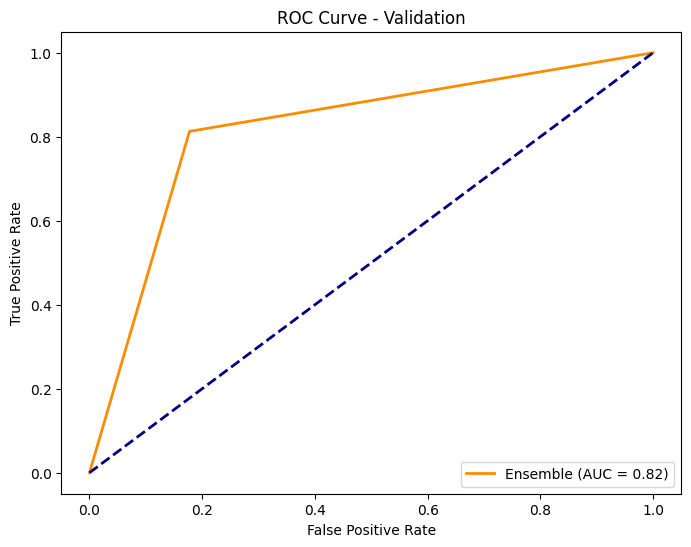

In [7]:
# Plot ROC for ensemble on validation
fpr, tpr, _ = roc_curve(val_labels, ens_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve - Validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

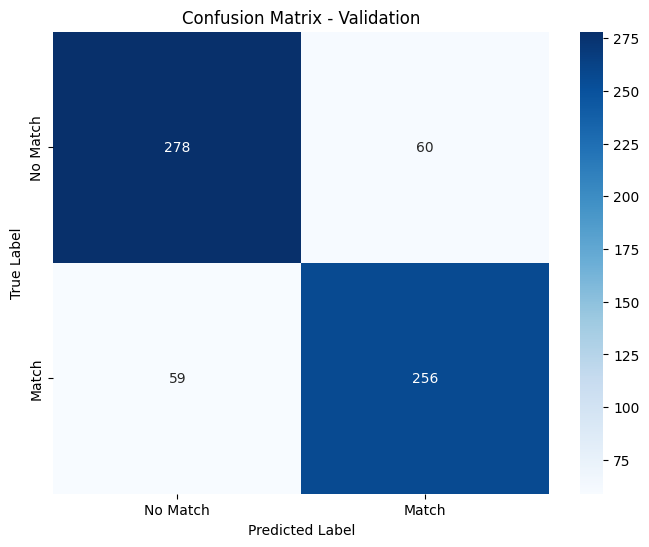

In [8]:
# Plot confusion matrix for ensemble
plt.figure(figsize=(8, 6))
cm = confusion_matrix(val_labels, ens_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Match', 'Match'], yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Validation')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
# Detailed classification report
print("\nEnsemble Validation Classification Report:")
print(classification_report(val_labels, ens_preds, target_names=['No Match', 'Match']))


Ensemble Validation Classification Report:
              precision    recall  f1-score   support

    No Match       0.82      0.82      0.82       338
       Match       0.81      0.81      0.81       315

    accuracy                           0.82       653
   macro avg       0.82      0.82      0.82       653
weighted avg       0.82      0.82      0.82       653



In [10]:
# Data quality check
print("\nData Quality Check")
print("=" * 40)
print("Training Data Columns:", train_df.columns.tolist())
print("Validation Data Columns:", val_df.columns.tolist())
print(f"Missing values in train:\n{train_df.isnull().sum()}")
print(f"Missing values in val:\n{val_df.isnull().sum()}")


Data Quality Check
Training Data Columns: ['cv_id', 'jd_id', 'cv_jd_similarity', 'cv_skill', 'jd_requirement', 'skill_requirement_similarity', 'ai_prediction', '__index_level_0__', 'cv_final', 'jd_final']
Validation Data Columns: ['cv_id', 'jd_id', 'cv_jd_similarity', 'cv_skill', 'jd_requirement', 'skill_requirement_similarity', 'ai_prediction', '__index_level_0__', 'cv_final', 'jd_final']
Missing values in train:
cv_id                           0
jd_id                           0
cv_jd_similarity                0
cv_skill                        0
jd_requirement                  0
skill_requirement_similarity    0
ai_prediction                   0
__index_level_0__               0
cv_final                        0
jd_final                        0
dtype: int64
Missing values in val:
cv_id                           0
jd_id                           0
cv_jd_similarity                0
cv_skill                        0
jd_requirement                  0
skill_requirement_similarity    0
a

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


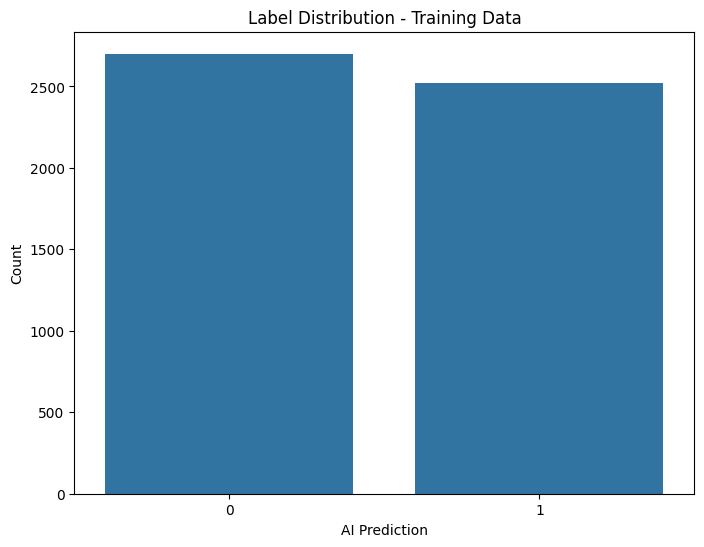

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


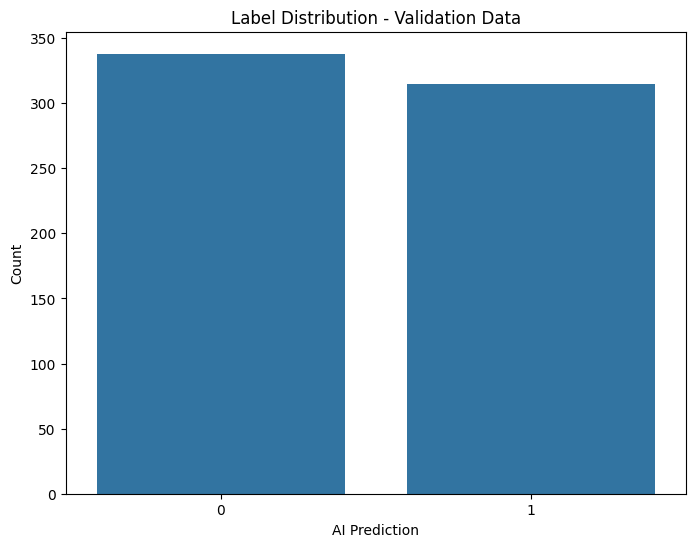

In [11]:
# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='ai_prediction', data=train_df)
plt.title('Label Distribution - Training Data')
plt.xlabel('AI Prediction')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='ai_prediction', data=val_df)
plt.title('Label Distribution - Validation Data')
plt.xlabel('AI Prediction')
plt.ylabel('Count')
plt.show()